# Borehole rock-physics
## Investigating the accuracy of various rock-physics transforms using borehole data

In [1]:
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)

In [2]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Create common masks and functions

In [3]:
def mask_nonan(df,nan_col_list):
    mask = df.notnull()
    return mask.loc[:,nan_col_list].all(axis=1)

def mask_noclay(df,nan_col_list):
    return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

def mask_SP_only(df,nan_col_list):
    return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

def mask_stds(df,nstds,testcol,nan_col_list):
    pop = df.loc[mask_nonan(df,nan_col_list),testcol]
    return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
                           pop > np.mean(pop)-nstds*np.std(pop))
def mask_wherescreen(df,nan_col_list):
    return  mask_nonan(df[df.screen.notnull()],nan_cols)

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def cond2rho(cond):
    return 1e4/cond

# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

In [4]:
recompute = False
clip_bad_data=True

if not recompute:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))
    MWnames = df.index.levels[0].values
else:
    ######## Convert all to feet from meters
    import glob
    from scipy.stats import mode
    def myround(x, base=.5):
        return base*np.round(x/base)

    f_MWm = glob.glob(lasdir.joinpath('MW-[1-9]Dm.las').as_posix())
    for f in f_MWm:
        lasobj = lasio.read(f)
        lasexpt = lasio.LASFile()

        for c in lasobj.curves:
            if c.mnemonic=='DEPT':
                continue
            lasexpt.insert_curve_item(0,c)
        #make sure DEPT is the first curve for aesthetics
        d = lasobj.get_curve('DEPT')
        d_mode = mode(np.diff(np.round(d.data/.3048,decimals=2))).mode[0]
        if d_mode==0.5:
            lasexpt.insert_curve(0,'DEPT',myround(d.data/.3048,base=.5),unit='F')
            lasexpt.write(f[:-5]+'f.las')
        else:
            raise Exception('Needs to be .5 feet')

    #########  Combine base las files with the digitized FRES and TMP las files
    def join_las(fname_base_las,fname_added_las,depthname='DEPT',freq=.5,exportname='export',writeyn=False):
        import lasio
        def check_type(las):
            if isinstance(las,Path) or isinstance(las,str):
                return lasio.read(Path(las).as_posix())
            else:
                return las

        baselas = check_type(fname_base_las)
        addlas = check_type(fname_added_las)

        #Line up the depths
        adddept = addlas[depthname]
        basedept = baselas[depthname]

        if freq!=.5:
            raise Exception('Currently only supported for half foot')

        add_dept_halffoot = adddept[addlas[depthname]%0.5==0]
        adddept2basedept = [np.where(ind==basedept)[0] for ind in list(add_dept_halffoot)]
        adddept2basedept = np.r_[[np.asscalar(ind) if len(ind)==1 else np.nan for ind in adddept2basedept]]
        mask = ~np.isnan(adddept2basedept)

        #Mask out nan values
        adddept2basedeptma = adddept2basedept[mask].astype('int32')

        for i,nam in enumerate(addlas.keys()):
            if nam==depthname:
                continue
            add_halffoot = addlas[nam][addlas[depthname]%0.5==0]
            add_halffootma = add_halffoot[mask]

            #Create data vector for bas las
            base_data_new = np.ones(len(basedept))*-999.25
            base_data_new[base_data_new==-999.25]  = np.nan
            base_data_new[adddept2basedeptma] = add_halffootma

            #Add the curve 
            baselas.add_curve(nam, base_data_new, unit=addlas.curves[i].unit)

        if writeyn:
            #export combined las object to .las + .csv files
            baselas.to_csv(Path(exportname).as_posix() + '.csv')
            baselas.write(Path(exportname).as_posix() + '.las')
        return baselas

    MWnos = [1,4,5,6,7,8,9]
    for i in range(len(MWnos)):
        f_base = glob.glob(lasdir.joinpath('MW-'+str(MWnos[i])+'Df.las').as_posix())[0]
        f_tmp =  glob.glob(lasdir.joinpath('mw'+str(MWnos[i])+'*.las').as_posix())
       #join tmp and fres if they're 2 separate files
        if len(f_tmp)==0:
            continue
        elif len(f_tmp)==1:
            las_tmp = lasio.read(f_tmp[0])
        elif len(f_tmp)==2:
            las_tmp = join_las(f_tmp[0],f_tmp[1],exportname=f_tmp[0]+'_joined',writeyn=False)
        #export all as .las and .csv
        las_out = join_las(f_base,las_tmp,exportname=f_base[:-5] + '_all',writeyn=True)
        
    ########## Create list of DataFrames
    f_MWall = glob.glob(lasdir.joinpath('MW-[1-9]D_all.las').as_posix())
    f_MWall = sorted(f_MWall,key=os.path.basename)
    MWnames = [Path(f).stem[:-4] for f in f_MWall]
    
    frames = []
    for f in f_MWall:
        las = lasio.read(f)
        #Convert to DF and mask for plots
        df_temp = las.df()
        frames.append(df_temp)

    ######### Meters to feet for lith and screen
    def m2ft(df,colname,newcolname=None):
        if newcolname is None:
            newcolname = colname + 'ft'
        df[newcolname] = df[colname]/.3048
        return

    mwlith= pd.read_excel(auxdir.joinpath('Lith_MPWSP.xlsx'))
    mwtds= pd.read_excel(auxdir.joinpath('TDS_Baseline_MPWSP.xlsx'),index_col=0)
    mwscreen = pd.read_excel(auxdir.joinpath('MPWSP_Screen.xlsx'),index_col=0)
    mwchem = pd.read_excel(auxdir.joinpath('WQ_Baseline_MPWSP.xlsx'),index_col=0)
    wellids = np.unique(mwlith['WellID'])

    m2ft(mwlith,'Top_m','topft')
    m2ft(mwlith,'Bottom_m','botft')
    m2ft(mwscreen,'Screen_Top','topft')
    m2ft(mwscreen,'Screen_Bottom','botft')

    
    ######## Assign lith, screen, and TDS measurements to each DataFrame
    def interval2point(pointdf,intervaldf,testcol,topcol='topft',botcol='botft'):
        df_list = []
        for d in pointdf.index:
            v=intervaldf[((d>=intervaldf[topcol]) & (d<intervaldf[botcol]))][testcol]
            if len(v)==1:
                df_list.append(v.values[0])
            elif len(v)>1:
                print(v)
                raise Exception('multiple values in this interval ??')
            else:
                df_list.append(np.nan)
        return df_list
    
    for i,frame in enumerate(frames):
        nam = MWnames[i]
        print('processing',nam)
        TDS1_list = np.nan*np.zeros(len(frame))
        TDS2_list = np.nan*np.zeros(len(frame))
        EC1_list = np.nan*np.zeros(len(frame))
        EC2_list = np.nan*np.zeros(len(frame))
        EC1f_list = np.nan*np.zeros(len(frame))
        EC2f_list = np.nan*np.zeros(len(frame))
        TMPf1_list = np.nan*np.zeros(len(frame))
        TMPf2_list = np.nan*np.zeros(len(frame))
        
        #Assign lith
        lith_list = interval2point(frame,mwlith.loc[lambda df: df['WellID'] == nam]
                   ,'Lith_Code_Orig',topcol='topft',botcol='botft')
        frame = frame.assign(lith=lith_list)

        #Assign screen and aquifer name
        screen_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'Alt_ID',topcol='topft',botcol='botft')
        aq_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'TargetedAquifer',topcol='topft',botcol='botft')
        aq_group_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'GroupedAquifer',topcol='topft',botcol='botft')
        
        frame = frame.assign(screen=screen_list)
        frame = frame.assign(Aquifer=aq_list)
        frame = frame.assign(AquiferGroup=aq_group_list)

        #Assign TDS measurements to each screen
        for scrn in ['Shallow','Med','Deep']:
            framebool = frame['screen']==scrn #entries in frame matching the well and screen
            screenbool = np.logical_and(mwtds.index == nam,mwtds['WellScreen'] == scrn[0]) #matching entries in mwtds
            chembool = np.logical_and(mwchem.index == nam,mwchem['WellScreen'] == scrn[0])
            nmeas = len(mwtds.loc[screenbool,'TDS(mg/L)'])
            if nmeas==2:
                TDS1_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[0]
                TDS2_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[1]     
                EC1_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[0]
                EC2_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[1] 
                EC1f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[0]
                EC2f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[1] 
                TMPf1_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[0]
                TMPf2_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[1] 
            elif nmeas==1:
                TMPf1_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[0]
                EC1_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[0]
                EC1f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[0]
                TDS1_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[0]
            else:
                print('Num of measurements:',nmeas)
                raise Exception('Number of measurements not equal to 1 or 2')

        frame = frame.assign(TDS1=TDS1_list)
        frame = frame.assign(TDS2=TDS2_list)
        frame = frame.assign(EC1=EC1_list)
        frame = frame.assign(EC2=EC2_list)
        frame = frame.assign(EC1f=EC1f_list)
        frame = frame.assign(EC2f=EC2f_list)
        frame = frame.assign(TMPf1=TMPf1_list)
        frame = frame.assign(TMPf2=TMPf2_list)
        frame[frame.loc[:,['TDS1','TDS2','EC1','EC2','EC1f','EC2f','TMPf1','TMPf2']]==0]=np.nan
        
        
        if clip_bad_data:
            ######### Record intervals of bad data at top and bottom of borehole
            topft = np.zeros(np.shape(MWnames))
            botft = np.zeros(np.shape(MWnames))
            data_rng = pd.DataFrame(np.r_[[MWnames,topft,botft]].T,columns=['Well','topft','botft'])
            def assign_top_bot(df,nam,top,bot):
                df.loc[df['Well']==nam,['topft','botft']] = (top,bot)
            assign_top_bot(data_rng,'MW-1D',100 ,330)
            assign_top_bot(data_rng,'MW-4D',0   ,331.0)
            assign_top_bot(data_rng,'MW-5D',75   ,426.5)
            assign_top_bot(data_rng,'MW-6D',40   ,400)
            assign_top_bot(data_rng,'MW-7D',70  ,345)
            assign_top_bot(data_rng,'MW-8D',30   ,350)
            assign_top_bot(data_rng,'MW-9D',5   ,392)
            #Do some manual clipping of bad data at the top and bottom of tracks
            top,bot =data_rng.loc[data_rng['Well']==nam,['topft','botft']].values[0]
            frame.loc[frame.index<top,['FRES','RILD']] = np.nan
            frame.loc[frame.index>bot,['FRES','RILD']] = np.nan   
        
        #Assign to list
        frames[i] = frame
        
    ######### Join all frames together
    df = pd.concat(frames, keys=MWnames, sort=False)

    
    ######### Replace 'Gravelly/silty sand w/clay' with 'SC-SM'
    df.loc[df.lith == 'Gravelly/silty sand w/clay','lith'] = 'SC-SM'

    ######### Add FRESc
    def degc2f(degc):
        return (degc*9/5)+32
    ref_temp= 77 #fahrenheit
    fresc = df.loc[:,'FRES']*(df.loc[:,'TMP']+6.77)/(ref_temp + 6.77)
    df=df.assign(FRESc = fresc);
    ec_fresc = cond2rho(df.loc[:,'EC1f'])*(degc2f(df.loc[:,'TMPf1'])+6.77)/(ref_temp + 6.77)
    df=df.assign(ec_fresc=ec_fresc)
    
    ######### Add aquifer number
    aqnum = -1*np.ones(len(df),dtype='Int32')
    aq_names = df[df.Aquifer.notna()].Aquifer.unique()
    aq_names.sort()
    for i,aq in enumerate(aq_names):
        aqnum[df.Aquifer == aq_names[i]] = i

    df=df.assign(aqnum=aqnum)

    ######### Save DF
    df_ind = pd.DataFrame(df.index.tolist(), columns=['Well','DEPT'])
    
    df.to_pickle(lasdir.joinpath('allMWs'))
    df_ind.to_pickle(lasdir.joinpath('allMWs_ind'))
    print('Done reprocessing from raw data!')

### 4 lithology categories applied to bagged trees

In [9]:
lithnum = np.zeros(len(df),dtype=np.int32)
lithnum_red = np.zeros(len(df),dtype=np.int32)
lithnum_bin= np.zeros(len(df),dtype=np.int32)
lithnum_bin_a =np.zeros(len(df),dtype=np.int32)
lithnum_bin_b = np.zeros(len(df),dtype=np.int32)
lithnum_bin_2ft= np.zeros(len(df),dtype=np.int32)



lithnam = [l for l in df.lith.unique() if str(l)!='nan']
lithnam.sort()


#4 lithologies (groups from UCSC)
lithnam_red = ['C','G','M','S']
lithnam2red = np.zeros(np.size(lithnam),dtype=np.int)


for i,redlith in enumerate(lithnam_red):
    for j,lith in enumerate(lithnam):
        if lith.startswith(redlith):
            lithnam2red[lithnam.index(lith)]=i

#Binary: Set anything that contains "C" or starts with "M" as "Cb"; else "Sb"
lithnam_bin = ['Cb','Sb']          
lithnam2bin= np.ones(np.size(lithnam),dtype=np.int)
for j,lith in enumerate(lithnam):
    if ('C' in lith) or (lith.startswith('M')):
        lithnam2bin[lithnam.index(lith)]=0

#Assign to df
for i,lith in enumerate(lithnam):
    lithnum[df.lith == lithnam[i]] = i
    lithnum_red[df.lith == lithnam[i]] = lithnam2red[lithnam.index(lithnam[i])]
    lithnum_bin[df.lith == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_a[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_b[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
    
df = df.assign(lithnum=lithnum)
df = df.assign(lithnum_red=lithnum_red)
df = df.assign(lithnum_bin=lithnum_bin)

df = df.assign(C=(lithnum_red==0).astype(np.int))
df = df.assign(G=(lithnum_red==1).astype(np.int))
df = df.assign(M=(lithnum_red==2).astype(np.int))
df = df.assign(S=(lithnum_red==3).astype(np.int))

df = df.assign(Cb=(lithnum_bin==0).astype(np.int))
df = df.assign(Sb=(lithnum_bin==1).astype(np.int))

df = df.assign(Cb_a=(lithnum_bin_a==0).astype(np.int))
df = df.assign(Sb_a=(lithnum_bin_a==1).astype(np.int))
df = df.assign(Cb_b=(lithnum_bin_b==0).astype(np.int))
df = df.assign(Sb_b=(lithnum_bin_b==1).astype(np.int))


### Create category of lith_above and lith_below

In [10]:
#Running average
wellids = df.index.levels[0].values
lithnum_bin_conv = np.zeros(len(df))
lith_above = np.zeros(len(df))
lith_below = np.zeros(len(df))
N=5 #Filter length
ind1 = 0
for nam in wellids:
    x= df.loc[nam].lithnum_bin.values
    ind2  = len(x) + ind1
    test = np.convolve(x, np.ones((N,))/N, mode='valid')
    lithnum_bin_conv[ind1:ind2] = np.r_[x[:int((N-1)/2)],test,x[-int((N-1)/2):]] #assign the original lith values to edge
    lith_above[ind1:ind2] = np.r_[x[:-1],np.nan]
    lith_below[ind1:ind2] = np.r_[np.nan,x[1:]]
    ind1=ind2


df = df.assign(lith_above=lith_above)
df = df.assign(lith_below=lith_below)
df= df.assign(lithnum_bin_conv=lithnum_bin_conv)

In [11]:
# df.loc[mask_nonan(df,nan_cols),'screen'].isna()

###  Archie's  Law
$$R_o = F*R_w $$
$$R_o = \phi^{-m}*R_w $$
### Arp's Law in degrees Fahrenheit
$$R_{w2} = R_{w1}\frac{T_1 + 6.77}{T_2 + 6.77}$$

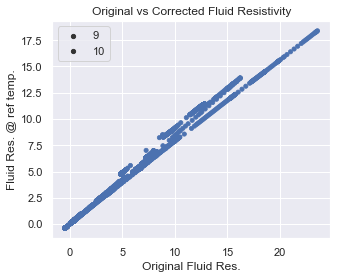

In [12]:
g = sns.scatterplot(data=df,x='FRES',y='FRESc',hue=None,edgecolor=None,size=10)
plt.gca().set_aspect(1)
plt.xlabel('Original Fluid Res.')
plt.ylabel('Fluid Res. @ ref temp.')
plt.title('Original vs Corrected Fluid Resistivity')
plt.show()

### Plot all boreholes: Bulk + fluid resistivity

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10


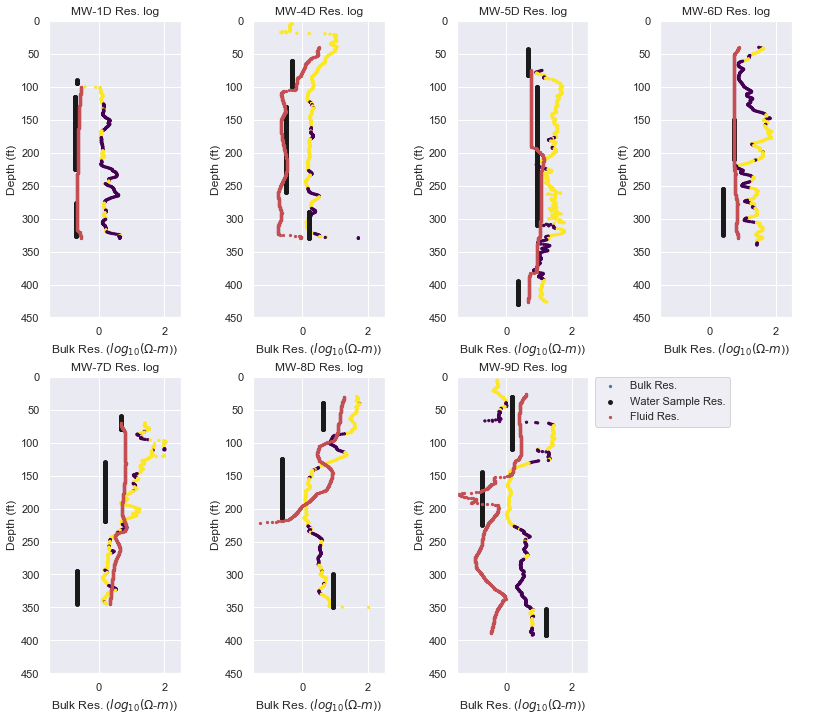

In [344]:
non_clays = ['SP','GP','SW','SM','SP-SM','ML','MH','SW-GW','SW-GP']
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot =  df[np.logical_and(np.logical_and(df.screen.notnull(),df.RILD.notnull()),df.lith=='SP')] 
# df_plot =  df[np.logical_and(df.RILD.notnull(),df.lith.isin(non_clays))] 
df_plot = df
s=5
f,axs=plt.subplots(2,4,figsize=(14,12))
plt.set_cmap('jet')
cmap = cm.get_cmap('viridis',len(df.lithnum_bin.unique()))  

for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i == axs.size-1:
        plt.axis('off')
        continue
    nam = MWnames[i]
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([0,450])
    ax.invert_yaxis()
    d=df_plot.loc[nam].index
    s1=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'RILD']),d,
                s=s, label='Bulk Res.',c=df_plot.loc[nam].loc[:,'lithnum_bin'],cmap=cmap)
    tds1 = plt.scatter(np.log10(df_plot.loc[nam].loc[:,'ec_fresc']),df.loc[nam].index,
                       c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
    s2=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'FRESc']),d,c='r',
                s=s,label='Fluid Res.')
    plt.vlines
    plt.ylabel('Depth (ft)')
    plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/50)
    plt.title(nam + ' Res. log');
    if i== axs.size-2:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.colorbar(tds1)
plt.savefig(figdir.joinpath('All_logs_lithology_bin.png'),dpi=500)

In [15]:
from scipy import stats
def x_y_regression(xin,yin,cin,msk=None,plotslp=True,slpname='F',plotone2one=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    f,ax = plt.subplots(1,figsize=(5,4))
    plt.scatter(x,y,c=c,**kwargs)
    plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
    if plotone2one:
        one2one = np.linspace(x.min(),x.max())
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
        plt.text(x.max()-(x.max()-x.min())*.75,y.max()-(y.max()-y.min())*.10,'{} = {:.2f} \n$R^2$ = {:.2f}'.format(slpname,slope,r_value**2))
    else:
        plt.text(x.max()-(x.max()-x.min())*.75,y.max(),'$R^2$ = {:.2f}'.format(r_value**2))
    return f,ax

### Applying Archie's Law: All measurements

<Figure size 432x288 with 0 Axes>

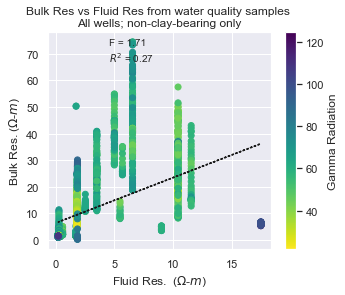

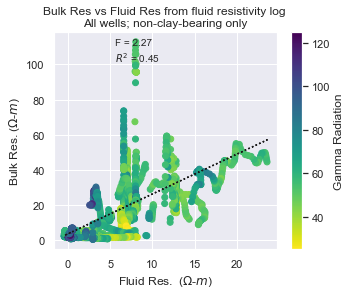

In [16]:
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot = df_plot.loc[mask_SP_only(df_plot,nan_cols),:]
# mask = mask_stds(df_plot,1.2,'RILD',nan_cols)
# df_plot =  df[np.logical_and(np.logical_and(df.screen.notnull(),df.RILD.notnull()),df.lith.isin(non_clays))]
df_plot =  df[np.logical_and(df.screen.notnull(),df.RILD.notnull())] 



x = cond2rho(df_plot.loc[:,'EC1f'])
y = df_plot.loc[:,'RILD']
c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax1 = x_y_regression(x,y,c);
ax1.set_title('Bulk Res vs Fluid Res from water quality samples \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
# plt.savefig(figdir.joinpath('FRESvEC1f_non_clay.png'),dpi=300)


df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))]

# df_plot =  df[np.logical_and(df.RILD.notnull(),df.FRES.notnull())] 

x = df_plot.loc[:,'FRES']
y = df_plot.loc[:,'RILD']
# c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax2 = x_y_regression(x,y,c,vmin=25,vmax=125);

ax2.set_title('Bulk Res vs Fluid Res from fluid resistivity log \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
# plt.savefig(figdir.joinpath('FRESvRILD_non_clay.png'),dpi=300)

### Archie's Law: borehole-by-borehole 

<Figure size 432x288 with 0 Axes>

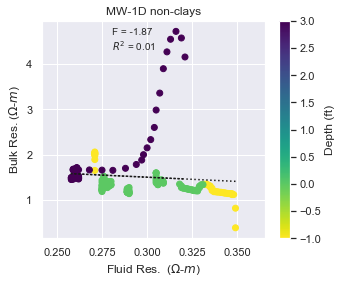

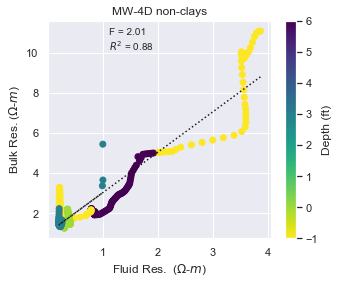

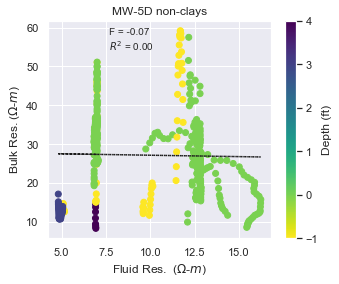

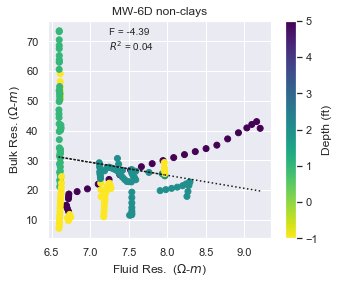

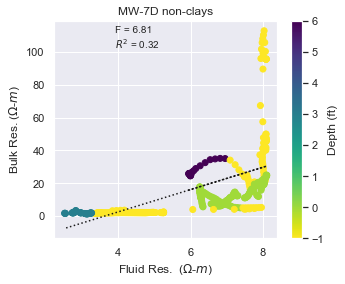

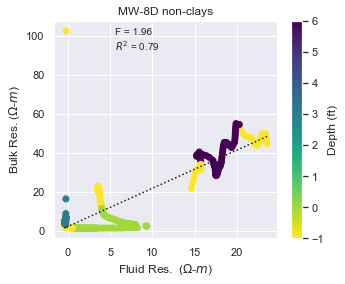

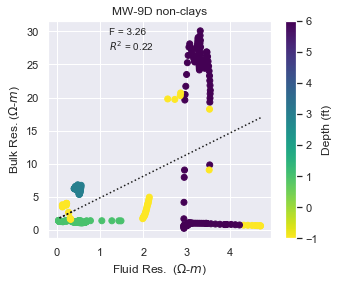

In [17]:

# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))] 

# mask = mask_nonan(df_plot,nan_cols)

for i,nam in enumerate(MWnames):
    x = df_plot.loc[nam].loc[:,'FRES']
    y = df_plot.loc[nam].loc[:,'RILD']
    c = df_plot.loc[nam].index
    c = df_plot.loc[nam].loc[:,'aqnum']
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam + ' non-clays')
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=90)
#     plt.savefig(figdir.joinpath('FRESvRILD_non_clay{}.png'.format(nam)),dpi=300)

### Archie's Law: aquifer-by-aquifer

In [20]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)


<Figure size 432x288 with 0 Axes>

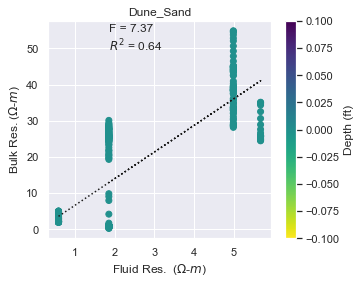

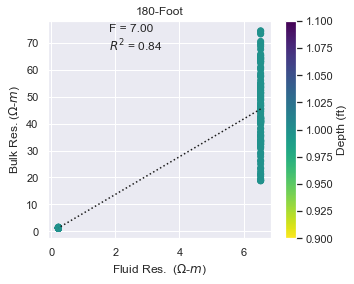

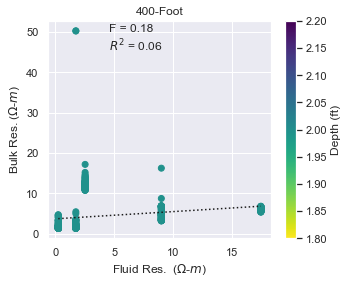

In [346]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df_plot = df[np.logical_and(df.RILD.notnull(),df.EC1f.notnull())] 
df_plot = df_plot.assign(logrhoEC1f = np.log10(cond2rho(df_plot.loc[:,'EC1f'])))
df_plot = df_plot.assign(logrild = np.log10(df_plot.loc[:,'RILD']))

df[df.Aquifer==aq_names[0]]

for i,nam in enumerate(aq_groupnames):
    x = cond2rho(df_plot[df_plot.Aquifer==nam].loc[:,'EC1f'])
    y = df_plot[df_plot.Aquifer==nam].loc[:,'RILD']
    c = df_plot[df_plot.Aquifer==nam].loc[:,'aq_groupnum']
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam)
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=90)
    plt.savefig(figdir.joinpath('WQvsRILD_'+nam+'.png'.format(nam)),dpi=300)

### Regression Tree v Classification Tree

In [22]:
def export_tree(export_dir,reg,max_depth,predictors,prefix='BagTree_',**kwargs):
    #Export graphs
    from sklearn import tree
    fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
    tree.export_graphviz(reg,out_file=export_dir.joinpath('tree.dot').as_posix(),filled=True,rounded=True,**kwargs)
    call(['dot', '-Tpng', figdir.joinpath('tree.dot').as_posix(), '-o',
    export_dir.joinpath(prefix+fig_suffix).as_posix(), '-Gdpi=300'])
    return

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

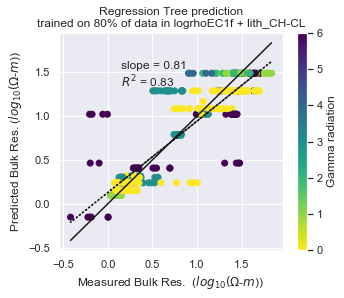

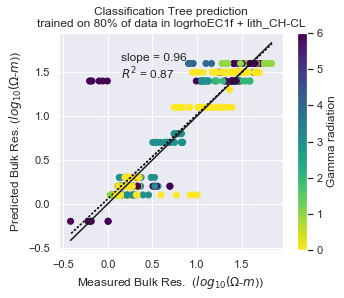

In [347]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
np.random.seed(1)
######## Prediction variables  ################
# ## Predict from FRES and lith
# predicted = 'logrild'
# predictors = ['logfres','lithnum']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]


# #Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
predictors = ['logrhoEC1f']
df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##############################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.sort_values(by='lith')
ohc = df_testing.loc[:,['lith']]
ohc =  pd.get_dummies(ohc,drop_first=True)
predictors = np.concatenate((predictors,ohc.columns.values))
df_testing = pd.get_dummies(df_testing,drop_first=False)

#Separate training from test data
y_all = df_testing.loc[:,predicted].values
df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=0.2)

y_train = y_train[:,0].astype(np.int)
y_test = y_test[:,1]

X_train = df_train.loc[:,predictors]
X_test = df_test.loc[:,predictors]

# Fit regression model
max_depth = 5

regr_1 = DecisionTreeRegressor(max_depth=max_depth)
regr_1.fit(X_train, y_train)

regr_2 = DecisionTreeClassifier(max_depth=max_depth)
regr_2.fit(X_train, y_train)


# Predict
y_1 = regr_1.predict(X_test)/10
y_2 = regr_2.predict(X_test)/10

#Plotting 
# mins = min(ax.get_ylim()[0],ax.get_xlim()[0])
# maxs = max(ax.get_ylim()[1],ax.get_xlim()[1])
# ax.plot(np.linspace(mins,maxs,10),np.linspace(mins,maxs,10))
# ax.set_aspect(1)
# cmap = cm.get_cmap('viridis',10 )  


f,ax = x_y_regression(y_test.squeeze(),
                      y_1,
                      df_test.aqnum,
                      plotslp=True,slpname='slope',plotone2one=True)#,cmap=cmap,vmin=25,vmax=100);
ax.set_title('Regression Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Gamma radiation', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
plt.savefig(figdir.joinpath('RegTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)


f,ax = x_y_regression(y_test.squeeze(),
                      y_2,
                      df_test.aqnum,
                      plotslp=True,slpname='slope',plotone2one=True)#,cmap=cmap,vmin=25,vmax=100);
ax.set_title('Classification Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Gamma radiation', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))


# #Export graphs
plt.savefig(figdir.joinpath('ClassTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)
export_tree(figdir,regr_1,max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

##### Interestingly, the classification tree, while it doesn't reduce the variance in the model, it does significantly reduce the bias, changing the $R^2$ from ~0.82 to ~0.96

### Bagging Trees for an estimate of uncertainty

In [349]:
def bagged_trees2(df,predicted,predictors,estimator=DecisionTreeRegressor,
                 train_ratio=.20,n_repeat=10,train_test_cols=None,verbose=True,**kwargs):
    #Separate training from test data
    y_all = df.loc[:,predicted]
    df_train, df_test, y_train, y_test = train_test_split(df, y_all, test_size=train_ratio)

    if train_test_cols is  None:
        train_test_cols = [predicted,predicted]
    else:
        y_test = y_test.loc[:,[train_test_cols[1]]]

    X_test = df_test.loc[:,predictors]
    regs = []
    X_train = []
    y_train = []
    for i in range(n_repeat):
        samp = resample(df_train,replace=True)
        X_train.append(samp.loc[:,predictors])
        y_train.append(samp.loc[:,[train_test_cols[0]]])

    # Compute predictions
    y_predict = np.zeros((len(y_test), n_repeat))

    for i in range(n_repeat):
        regs.append(estimator(**kwargs))
        regs[-1].fit(X_train[i], y_train[i])
        y_predict[:, i] = regs[-1].predict(X_test)


    y_est = y_predict.mean(axis=1)
    y_error = np.zeros(y_test.size)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
    y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
    y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
    y_var = np.var(y_predict,axis=1)
    if verbose:
        print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
              "+ {2:.4f} (var)".format(np.mean(y_error),
                                       np.mean(y_bias),
                                       np.mean(y_var)))
        print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
              "+ {2:.2f}% (var)".format(np.mean(y_error),
                                       100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                                       100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))
    return regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test)




### 4 lithology categories applied to bagged trees

In [110]:
lithnum = np.zeros(len(df),dtype=np.int32)
lithnum_red = np.zeros(len(df),dtype=np.int32)
lithnum_bin= np.zeros(len(df),dtype=np.int32)
lithnum_bin_a =np.zeros(len(df),dtype=np.int32)
lithnum_bin_b = np.zeros(len(df),dtype=np.int32)
lithnum_bin_2ft= np.zeros(len(df),dtype=np.int32)



lithnam = [l for l in df.lith.unique() if str(l)!='nan']
lithnam.sort()


#4 lithologies (groups from UCSC)
lithnam_red = ['C','G','M','S']
lithnam2red = np.zeros(np.size(lithnam),dtype=np.int)


for i,redlith in enumerate(lithnam_red):
    for j,lith in enumerate(lithnam):
        if lith.startswith(redlith):
            lithnam2red[lithnam.index(lith)]=i

#Binary: Set anything that contains "C" or starts with "M" as "Cb"; else "Sb"
lithnam_bin = ['Cb','Sb']          
lithnam2bin= np.ones(np.size(lithnam),dtype=np.int)
for j,lith in enumerate(lithnam):
    if ('C' in lith) or (lith.startswith('M')):
        lithnam2bin[lithnam.index(lith)]=0

#Assign to df
for i,lith in enumerate(lithnam):
    lithnum[df.lith == lithnam[i]] = i
    lithnum_red[df.lith == lithnam[i]] = lithnam2red[lithnam.index(lithnam[i])]
    lithnum_bin[df.lith == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_a[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_b[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
    
df = df.assign(lithnum=lithnum)
df = df.assign(lithnum_red=lithnum_red)
df = df.assign(lithnum_bin=lithnum_bin)

df = df.assign(C=(lithnum_red==0).astype(np.int))
df = df.assign(G=(lithnum_red==1).astype(np.int))
df = df.assign(M=(lithnum_red==2).astype(np.int))
df = df.assign(S=(lithnum_red==3).astype(np.int))

df = df.assign(Cb=(lithnum_bin==0).astype(np.int))
df = df.assign(Sb=(lithnum_bin==1).astype(np.int))

df = df.assign(Cb_a=(lithnum_bin_a==0).astype(np.int))
df = df.assign(Sb_a=(lithnum_bin_a==1).astype(np.int))
df = df.assign(Cb_b=(lithnum_bin_b==0).astype(np.int))
df = df.assign(Sb_b=(lithnum_bin_b==1).astype(np.int))


### Create category of lith_above, lith_below, and lithnum_bin_conv

In [305]:
#Running average
wellids = df.index.levels[0].values
lithnum_bin_conv = np.zeros(len(df))
lith_above = np.zeros(len(df))
lith_below = np.zeros(len(df))
N=5 #Filter length
ind1 = 0
for nam in wellids:
    x= df.loc[nam].lithnum_bin.values
    ind2  = len(x) + ind1
    test = np.convolve(x, np.ones((N,))/N, mode='valid')
    lithnum_bin_conv[ind1:ind2] = np.r_[x[:int((N-1)/2)],test,x[-int((N-1)/2):]] #assign the original lith values to edge
    lith_above[ind1:ind2] = np.r_[x[:-1],np.nan]
    lith_below[ind1:ind2] = np.r_[np.nan,x[1:]]
    ind1=ind2


df = df.assign(lith_above=lith_above)
df = df.assign(lith_below=lith_below)
df= df.assign(lithnum_bin_conv=lithnum_bin_conv)

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -All 22 lithology classifiers

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


81.1674 (MSE) = 80.0228 (bias^2)+ 1.1445 (var)
81.1674 (MSE) = 98.59% (bias^2)+ 1.41% (var)


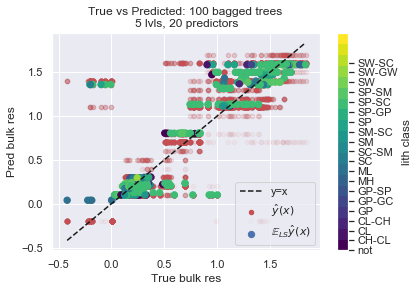

<Figure size 432x288 with 0 Axes>

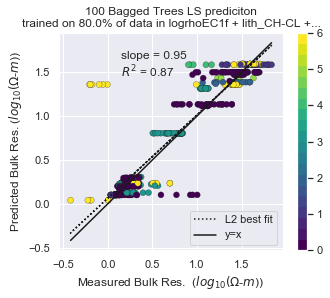

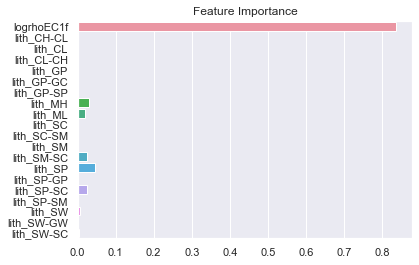

In [348]:
# #Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
predictors = ['logrhoEC1f']
estimator= DecisionTreeClassifier

df_testing = df[np.logical_and(np.logical_and(
    df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrilm = np.log10(df_testing.RILM))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.sort_values(by='lith')
ohc = df_testing.loc[:,['lith']]
ohc =  pd.get_dummies(ohc,drop_first=True)
predictors = np.concatenate((predictors,ohc.columns.values))
df_testing = pd.get_dummies(df_testing,drop_first=False)

regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',len(predictors))  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      df_test.aqnum,
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data in {}'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
plt.colorbar()
# cb = f.colorbar(ax.collections[0],ax=ax,ticks=np.arange(len(predictors)))
# cb.set_label('lith class', rotation=90)
# # cb.ax.set_ylim([-.1,1.1])
# pred_label = [pred for pred in predictors[1:]]
# cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar
plt.show();


scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');


#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -Binary lithology
###### -Aquifer number
###### -Convolved lithology: 2.5-ft-wide moving filter of binary lithology (Sand=1,Clay=0)

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


78.6520 (MSE) = 77.8641 (bias^2)+ 0.7878 (var)
78.6520 (MSE) = 99.00% (bias^2)+ 1.00% (var)


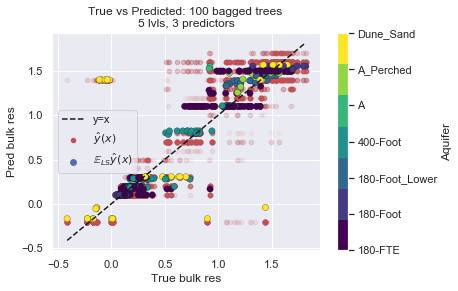

<Figure size 432x288 with 0 Axes>

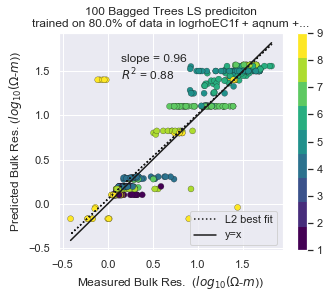

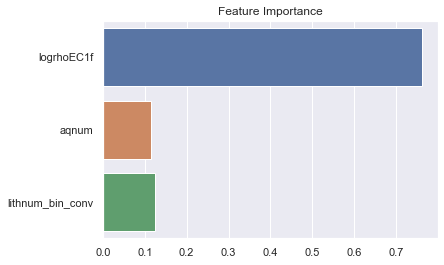

In [359]:
np.random.seed(1)

n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['logrhoEC1f','aqnum','lithnum_bin_conv']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                              train_ratio=train_ratio,
                              train_test_cols=train_test_cols,
                              n_repeat=n_repeat,
                              estimator=estimator,
                              max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)

#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',len(df_testing.aqnum.unique()))  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
y_est = y_predict.mean(axis=1)



plt.scatter(y_test, y_est, c=spreadcolor,s=s,
                label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.loc[:,colorcolumn],
                label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,
                cmap=cmap,edgecolors='k',linewidth=.25)

one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax)#,ticks=np.arange(len(aq_names)))
cb.set_label('Aquifer', rotation=90)
cb.set_ticks(np.arange(len(aq_names)))
cb.ax.set_yticklabels(aq_names)  # vertically oriented colorbar


plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
cmap = cm.get_cmap('viridis',9)  
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      #df_test.loc[:,colorcolumn],
                      [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',
                      edgecolors='k',linewidth=.25,cmap=cmap)#,vmin=25,vmax=100);
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k',label='y=x')
if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data in {}'
             .format(n_repeat,(1-train_ratio)*100,
                     predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0])
# cb = f.colorbar(ax.collections[0],ax=ax,ticks=np.arange(len(predictors)))
# cb.set_label('Reduced lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
# cb.ax.set_yticklabels(np.hstack(('not',predictors[1:])).astype(str))  # vertically oriented colorbar
plt.show();

scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');

### Uncertainty estimate: effect of changing the train/test groups

In [351]:
from numpy.linalg import norm
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['logrhoEC1f','aqnum','lithnum_bin_conv']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))



n_it = 100
MSE = []
norm_err=[]
for s in range(n_it):
    if np.mod(s,5)==0:
        print('iteration',s)
    np.random.seed(s)
    regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                                  train_ratio=train_ratio,
                                  train_test_cols=train_test_cols,
                                  n_repeat=n_repeat,
                                  verbose=False,  
                                  estimator=estimator,
                                  max_depth=max_depth)

    y_predict /=10
    MSE.append(np.power(y_predict - np.tile(y_test,n_repeat),2).mean())
    norm_err.append(norm(y_predict - np.tile(y_test.values,[1,n_repeat]),ord=2)
                    /norm(np.tile(y_test.values,[1,n_repeat]),ord=2))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


Text(0, 0.5, 'count')

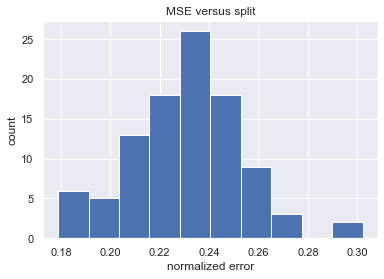

In [356]:
plt.hist(norm_err,label='Norm. Error')
# plt.hist(MSE,label='MSE')

plt.title('Normalized error versus split')
plt.xlabel('normalized error')
plt.ylabel('count')


### Use Bagging Classifier through sklearn

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

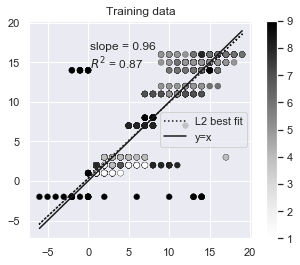

<Figure size 432x288 with 0 Axes>

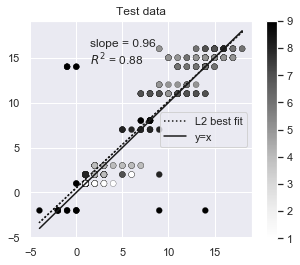

In [249]:
from sklearn.ensemble import BaggingClassifier
np.random.seed(1)

n_repeat = 200     # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
n_estimators = n_repeat


####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_bin'
train_test_cols=predicted

predictors = ['logrhoEC1f','lithnum_bin','aqnum','lithnum_bin_conv']
colorcolumn = 'aq_groupnum'
estimator=BaggingClassifier(DecisionTreeClassifier(
    max_depth=max_depth),n_estimators=n_estimators)

df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))


#######################################
#Separate training from test data
X = df_testing.loc[:,predictors]
y = df_testing.loc[:,predicted]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_ratio)

estimator.fit(X_train,y_train)
y_predict = estimator.predict(X_test)
y_train_predict = estimator.predict(X_train)
f,ax = x_y_regression(y_train.values.squeeze(),
                      y_train_predict.squeeze(),
                      [int(nam[3]) for nam in pd.DataFrame(y_train.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=.25,cmap='Greys')#,vmin=25,vmax=100);
plt.legend(loc='right')
plt.colorbar()
plt.title('Training data')
plt.show()

f,ax = x_y_regression(y_test.values.squeeze(),
                      y_predict.squeeze(),
                      [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=.25,cmap='Greys')#,vmin=25,vmax=100);
plt.legend(loc='right')
plt.colorbar()
plt.title('Test data')
plt.show()

#### The bagging classifier ends up with nearly the exact same prediction as with the manually bagged trees. Difference is that with the manual approach, I can plot each of the predictions as an estimate of variance

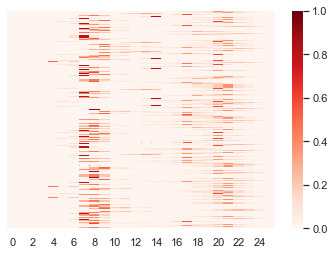

In [199]:
sns.heatmap(estimator.predict_proba(X_test),yticklabels='',cmap='Reds')


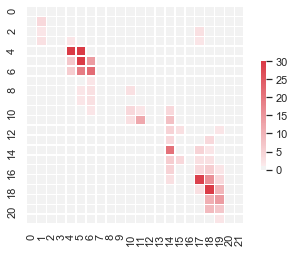

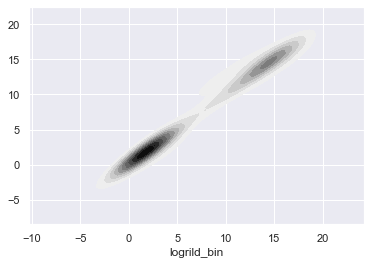

In [193]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test,y_predict)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(conf, cmap=cmap, vmax=30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()
sns.kdeplot(y_test,y_predict,cmap="Greys", shade=True, shade_lowest=False,n_levels=10)


In [ ]:
y_all = df_testing.loc[:,predicted]




df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=train_ratio)

y_test = y_test.loc[:,'logrild']

X_test = df_test.loc[:,predictors]
regs = []
X_train = []
y_train = []
for i in range(n_repeat):
    samp = resample(df_train,replace=True)
    X_train.append(samp.loc[:,predictors])
    y_train.append(samp.loc[:,[train_test_cols[0]]])

# Compute predictions
y_predict = np.zeros((len(y_test), n_repeat))

for i in range(n_repeat):
    regs.append(estimator(**kwargs))
    regs[-1].fit(X_train[i], y_train[i])
    y_predict[:, i] = regs[-1].predict(X_test)


y_est = y_predict.mean(axis=1)
y_error = np.zeros(y_test.size)

# Bias^2 + Variance + Noise decomposition of the mean squared error
y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
y_var = np.var(y_predict,axis=1)

print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
      "+ {2:.4f} (var)".format(np.mean(y_error),
                               np.mean(y_bias),
                               np.mean(y_var)))
print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
      "+ {2:.2f}% (var)".format(np.mean(y_error),
                               100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                               100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))




Tree: 0.0250 (error) = 0.0001 (bias^2)  + 0.0149 (var) + 0.0100 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0100 (noise)


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.0194 (error) = 0.0009 (bias^2)  + 0.0085 (var) + 0.0100 (noise)
Ada: 0.0240 (error) = 0.0027 (bias^2)  + 0.0113 (var) + 0.0100 (noise)


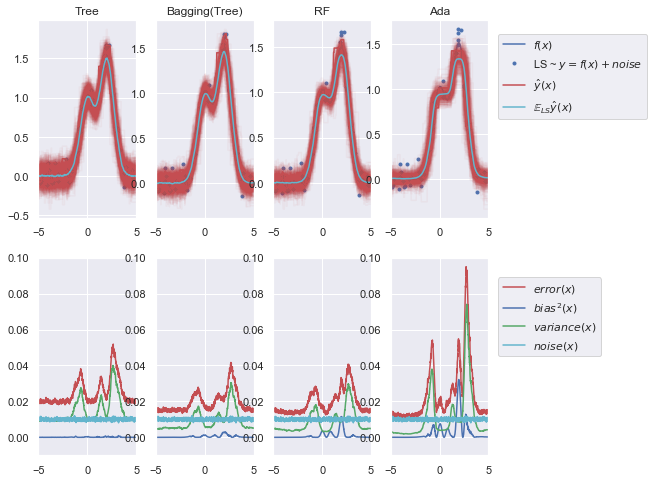

In [110]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 200       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(1)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
               ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
               ("RF", RandomForestRegressor(max_depth=5)),
             ("Ada",AdaBoostRegressor())]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([-.01, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()